In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from torch.utils.data import TensorDataset,DataLoader, random_split

fnexpr='exprLOW.csv'
fnmet='methylLOW.csv'
fnassig='assignLOW.csv'
nsamp=10000
fnmodel='G-MTE1-10K.pth'
fnmodeld='D-MTE1-10K.pth'
filename = "MTE1-10K-"

#Función para contar número de parámetros del modelo
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
# Definir el generador y el discriminador
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            #nn.Linear(512, 1024),
            #nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, output_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
        )
        
    def forward(self, x):
        return self.net(x)
        
# Leer datos
expression_data = pd.read_csv(fnexpr)
methylation_data = pd.read_csv(fnmet)
assign_data = pd.read_csv(fnassig)

expression_data = expression_data.iloc[:, 1:]
methylation_data = methylation_data.iloc[:, 1:]
assign_data = assign_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')
methylation_data = methylation_data.apply(pd.to_numeric, errors='coerce')
assign_data = assign_data.apply(pd.to_numeric, errors='coerce')

# Lidiar con valores NaN (si los hay). Pone 0(CAMBIAR)
#expression_data.fillna(0, inplace=True)
#methylation_data.fillna(0, inplace=True)
#assign_data.fillna(0, inplace=True)

#Normalizamos
scaler = MinMaxScaler()

# Asumiendo que expression_data, methylation_data y assign_data son tus DataFrames
expression_data_scaled = scaler.fit_transform(expression_data)
methylation_data_scaled = scaler.fit_transform(methylation_data)
assign_data_scaled =assign_data

# Convertir a DataFrame
expression_data = pd.DataFrame(expression_data_scaled, index=expression_data.index, columns=expression_data.columns)
methylation_data = pd.DataFrame(methylation_data_scaled, index=methylation_data.index, columns=methylation_data.columns)
assign_data = pd.DataFrame(assign_data_scaled, index=assign_data.index, columns=assign_data.columns)

#print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device="cpu"

# Convertir a Tensor y pasar a GPU
expression_data_tensor = torch.FloatTensor(expression_data.values).to(device)
methylation_data_tensor = torch.FloatTensor(methylation_data.values).to(device)
#assign_data = torch.FloatTensor(assign_data.values).to(device)
#combined_data = torch.cat((expression_data,methylation_data), 1).to(device)

# Dividir en conjuntos de entrenamiento y prueba
dataset = TensorDataset(expression_data_tensor, methylation_data_tensor)
train_size = int(0.9 * len(dataset))  # Ajusta esto según tu necesidad
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Convertir los Subset en tensores para el entrenamiento
expression_train, methylation_train= zip(*[(e, m) for e, m in train_dataset])
expression_train = torch.stack(expression_train)
methylation_train = torch.stack(methylation_train)
#assign_train = torch.stack(assign_train)

# Convertir los Subset en tensores para la validación/prueba
expression_test, methylation_test = zip(*[(e, m) for e, m in test_dataset])
expression_test = torch.stack(expression_test)
methylation_test = torch.stack(methylation_test)
#assign_test = torch.stack(assign_test)


In [4]:





# Modelos y optimizadores
gen = Generator(methylation_data.shape[1], expression_data.shape[1]).to(device)
disc = Discriminator(expression_data.shape[1] + methylation_data.shape[1]).to(device)
#gen.load_state_dict(torch.load(fnmodel))
#disc.load_state_dict(torch.load(fnmodeld))
print(f'El modelo Generator tiene {count_parameters(gen)} parámetros entrenables.')
print(f'El modelo Discriminator tiene {count_parameters(disc)} parámetros entrenables.')
gen_optimizer = optim.RMSprop(gen.parameters(), lr=0.0002)
disc_optimizer = optim.RMSprop(disc.parameters(), lr=0.0002)


# Hiperparámetros adicionales
n_critic = 5 # Número de veces que se actualiza el discriminador por cada actualización del generador
lambda_gp = 10 # Coeficiente de penalización de gradiente

# Función de penalización de gradiente
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calcula la penalización del gradiente para WGAN-GP."""
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(real_samples.size(0), 1).to(device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


# Entrenamiento
#n_samples = combined_data.size(0)
batch_size = 64
start_epoch=0
n_epochs = 10000
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
start_time = time.time()
for epoch in range(start_epoch,n_epochs):
    counter=0
    for batch in train_loader:
        # Entrenamiento del discriminador
        expression_data, methylation_data = batch
        expression_data = expression_data.to(device)
        methylation_data = methylation_data.to(device)
        real_data =torch.cat((expression_data,methylation_data ), 1).to(device)
        
        for nc in range(n_critic):
            #real_data = combined_data[idx:idx+batch_size].to(device)
            #current_batch_size = real_data.size(0)
           
            disc_optimizer.zero_grad()

            noise = methylation_data
            fake_expr = gen(noise).to(device)
            fake_data = torch.cat((fake_expr,methylation_data ), 1).to(device)
            if ((epoch+1) % 100 == 0) and (counter==0) and (nc==0):
                print(fake_data)
            real_preds = disc(real_data).to(device)
            fake_preds = disc(fake_data).to(device)
            
            # WGAN loss
            d_real_loss = -torch.mean(real_preds)
            d_fake_loss = torch.mean(fake_preds)
            
            gradient_penalty = compute_gradient_penalty(disc, real_data.data, fake_data.data)
            d_loss = d_real_loss + d_fake_loss + lambda_gp * gradient_penalty
            
            d_loss.backward()
            disc_optimizer.step()

        # Entrenamiento del generador
        gen_optimizer.zero_grad()
        
        noise = methylation_data
        fake_expr = gen(noise).to(device)
        fake_data = torch.cat((fake_expr,methylation_data ), 1).to(device)
        fake_preds = disc(fake_data).to(device)

        # WGAN loss
        g_loss = -torch.mean(fake_preds)
        
        g_loss.backward()
        gen_optimizer.step()
        counter+=1
        
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Disc Loss: {d_loss.item()} | Gen Loss: {g_loss.item()}")
        end_time = time.time()

        # Calcular la diferencia de tiempo
        elapsed_time = end_time - start_time

        print(f"El código tardó {elapsed_time:.5f} segundos en ejecutarse.")
        start_time = time.time()

        torch.save(gen.state_dict(), fnmodel)
        torch.save(gen.state_dict(), fnmodeld)
    


       # Loss basado en la capacidad de engañar al discriminador
        #gan_loss = criterion(fake_preds, real_labels)

        # MSE loss entre el metilación generado y el metilación real
        #mse_loss = mse_criterion(fake_methyl,  torch.cat((methylation_data[idx:idx+batch_size],assign_data[idx:idx+batch_size]),1).to(device))

        # Combina ambos losses. El coeficiente 'alpha' permite ponderar la importancia relativa de cada loss.
        #alpha = 0.9
        #gen_loss = gan_loss + alpha * mse_loss

        #gen_loss.backward()
        #gen_optimizer.step()




El modelo Generator tiene 2744451 parámetros entrenables.
El modelo Discriminator tiene 1167361 parámetros entrenables.
tensor([[0.1992, 0.5199, 0.7500,  ..., 0.1411, 0.0629, 0.1070],
        [0.1725, 0.4366, 0.7370,  ..., 0.2273, 0.0874, 0.1385],
        [0.2130, 0.4742, 0.7643,  ..., 0.3741, 0.1423, 0.1599],
        ...,
        [0.1252, 0.7503, 0.7378,  ..., 0.1898, 0.0946, 0.1936],
        [0.2266, 0.6623, 0.7833,  ..., 0.6241, 0.1384, 0.3000],
        [0.1597, 0.3678, 0.7856,  ..., 0.1606, 0.1176, 0.0778]],
       device='cuda:0', grad_fn=<CatBackward0>)
Epoch 100/10000 | Disc Loss: -0.2274380326271057 | Gen Loss: 0.5217233300209045
El código tardó 247.73558 segundos en ejecutarse.
tensor([[0.2195, 0.3458, 0.7200,  ..., 0.3147, 0.1337, 0.3135],
        [0.1854, 0.4597, 0.8205,  ..., 0.1349, 0.0661, 0.1152],
        [0.9071, 0.3592, 0.2510,  ..., 0.2589, 0.0285, 0.0689],
        ...,
        [0.1710, 0.6292, 0.7403,  ..., 0.3261, 0.1901, 0.1566],
        [0.2296, 0.4644, 0.7354,  .

/home/fede/PyEnv/PB/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-04 03:38:11.735057: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 03:38:11.760545: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 03:38:11.760566: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 03:38:11.760583: E

True
MSE entre los datos de metilación reales y los generados: 0.04053976759314537
RMSE: 0.20134489711225703
PCC: 0.5393420704448616


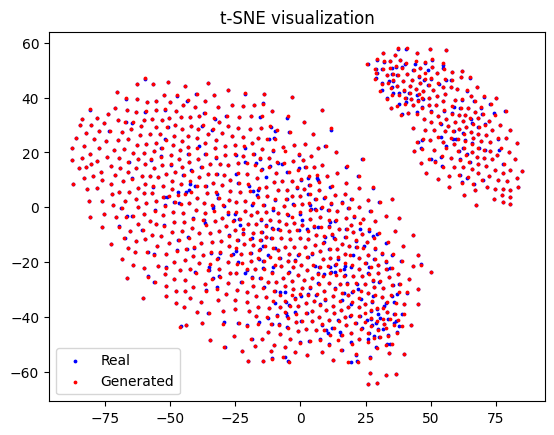

/home/fede/PyEnv/PB/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


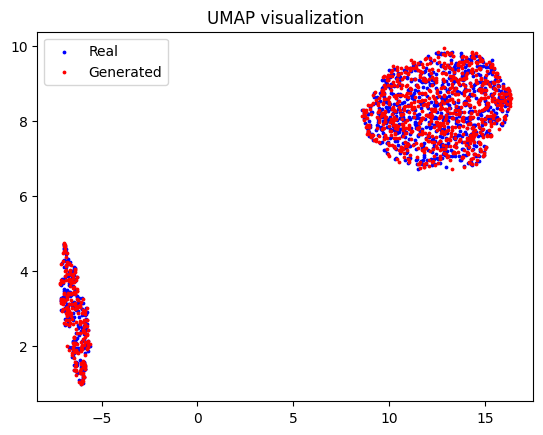

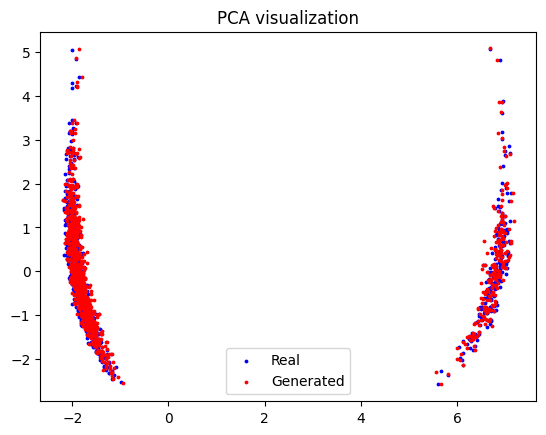

In [5]:
import torch
import pandas as pd
from sklearn.metrics import mean_squared_error
from torch.nn.functional import mse_loss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from scipy.stats import wasserstein_distance, ks_2samp
import sys
import umap
from scipy.stats import pearsonr
from math import sqrt
#expression_data_test_tensor, methylation_data_test_tensor = zip(*[(e, m) for e, m in test_dataset])


# Convertir los tensores a numpy y luego a DataFrame de pandas
expression_data_test_np = expression_test.cpu().numpy()
methylation_data_test_np = methylation_test.cpu().numpy()

#expression_data_test_tensor = torch.FloatTensor(expression_data_test_np).to(device)
expression_data_test_df = pd.DataFrame(expression_data_test_np)
methylation_data_test_df = pd.DataFrame(methylation_data_test_np)



X_real = pd.concat([expression_data_test_df, methylation_data_test_df], axis=1)
# Concatenar los datos
#combined_data =torch.FloatTensor(np.hstack((expression_data, methylation_data,assign_data)))
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device="cpu"

# Carga del modelo previamente entrenado
gen = Generator(methylation_data.shape[1], expression_data.shape[1]).to(device)
gen.load_state_dict(torch.load(fnmodel))
gen.eval()
gen.to(device)



# Pasar todos los datos de expr.csv a través del generador
with torch.no_grad():
    generated_expr = gen(methylation_test)

# Asegúrate de que los datos generados y los datos reales estén en la misma forma
generated_expr = generated_expr.cpu().numpy()

# Aquí estamos asumiendo que la primera parte de la salida generada corresponde a methyl.csv
# Si tu salida generada incluye más datos además de methyl.csv, necesitas ajustar esto
generated_expr_data = generated_expr[:, :expression_test.shape[1]]






generated_expr_data_df=pd.DataFrame(generated_expr_data)
X_gan = pd.concat([generated_expr_data_df, methylation_data_test_df], axis=1)
#last_column = X_gan.columns[-1]
#X_gan = X_gan.drop(columns=[last_column])
X_gan.columns = X_real.columns
# Concatena los datos reales con los generados
X_combined = np.vstack([X_real, X_gan])

#generated_methyl_data_np = generated_methyl_data.cpu().numpy()

# Calcular el MSE
mse = mean_squared_error(expression_data_test_np, generated_expr_data)

print(f"MSE entre los datos de metilación reales y los generados: {mse}")
rmse = sqrt(mse)
print(f"RMSE: {rmse}")
pcc, _ = pearsonr(expression_data_test_np.flatten(), generated_expr_data.flatten())
print(f"PCC: {pcc}")

labels = np.concatenate([np.ones(X_real.shape[0]), np.zeros(X_gan.shape[0])])
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_combined)

plt.scatter(X_tsne[labels==1, 0], X_tsne[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_tsne[labels==0, 0], X_tsne[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('t-SNE visualization')
plt.savefig(filename+"tsne.jpg")
plt.show()

# Configurando y entrenando UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_combined)

# Dibujando la visualización
plt.scatter(X_umap[labels==1, 0], X_umap[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_umap[labels==0, 0], X_umap[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('UMAP visualization')
plt.savefig(filename+"umap.jpg")
plt.show()


#PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

plt.scatter(X_pca[labels==1, 0], X_pca[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_pca[labels==0, 0], X_pca[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('PCA visualization')
plt.savefig(filename+"pca.jpg")
plt.show()